# Reading multiple files and optimizing memory use
With the ever-growing amount of data, it is crucial to be able to analyse big "out of memory" data. In this notebook, we will focus on utilizing xarray and dask to handle multiple files that have a combined size of 100s GB to even 1TB.

## Importing Libraries

In [1]:
import xarray as xr
import numpy as np # you can use numpy functions with xarray objects
import glob # a library to handle path/folder/file related issues
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

## Opening multiple netcdf files

xarray's open_mfdataset can open multiple files and merge them into one dataset automatically. You can either speicify the input file lists or let xarray to find matching files automatically. Xarray will try to find the dimension along witch to stack them together or you can also specify if you want.

### Getting filenames ready

#### Filenames for all years

In [2]:
u_files=sorted(glob.glob('/mnt/Metservice_WRF/U_*',recursive=False)) #glob is a useful function for getting all the files within a folder

In [3]:
# run this cell to check that the variable has the correct filenames in it. 
# This variable (u_files) will be called again when the xarray mfdataset is executed below.
u_files

['/mnt/Metservice_WRF/U_20000101000000.nc',
 '/mnt/Metservice_WRF/U_20000201000000.nc',
 '/mnt/Metservice_WRF/U_20000301000000.nc',
 '/mnt/Metservice_WRF/U_20000401000000.nc',
 '/mnt/Metservice_WRF/U_20000501000000.nc',
 '/mnt/Metservice_WRF/U_20000601000000.nc',
 '/mnt/Metservice_WRF/U_20000701000000.nc',
 '/mnt/Metservice_WRF/U_20000801000000.nc',
 '/mnt/Metservice_WRF/U_20000901000000.nc',
 '/mnt/Metservice_WRF/U_20001001000000.nc',
 '/mnt/Metservice_WRF/U_20001101000000.nc',
 '/mnt/Metservice_WRF/U_20001201000000.nc',
 '/mnt/Metservice_WRF/U_20010101000000.nc',
 '/mnt/Metservice_WRF/U_20010201000000.nc',
 '/mnt/Metservice_WRF/U_20010301000000.nc',
 '/mnt/Metservice_WRF/U_20010401000000.nc',
 '/mnt/Metservice_WRF/U_20010501000000.nc',
 '/mnt/Metservice_WRF/U_20010601000000.nc',
 '/mnt/Metservice_WRF/U_20010701000000.nc',
 '/mnt/Metservice_WRF/U_20010801000000.nc',
 '/mnt/Metservice_WRF/U_20010901000000.nc',
 '/mnt/Metservice_WRF/U_20011001000000.nc',
 '/mnt/Metservice_WRF/U_20011101

#### Filenames for a sepcifc year

In [4]:
# Now try to be specifc to what years you are calling. This can be done using wildcards.
u_files_2010=sorted(glob.glob('/mnt/Metservice_WRF/U_2010*',recursive=False))
u_files_2010

['/mnt/Metservice_WRF/U_20100101000000.nc',
 '/mnt/Metservice_WRF/U_20100201000000.nc',
 '/mnt/Metservice_WRF/U_20100301000000.nc',
 '/mnt/Metservice_WRF/U_20100401000000.nc',
 '/mnt/Metservice_WRF/U_20100501000000.nc',
 '/mnt/Metservice_WRF/U_20100601000000.nc',
 '/mnt/Metservice_WRF/U_20100701000000.nc',
 '/mnt/Metservice_WRF/U_20100801000000.nc',
 '/mnt/Metservice_WRF/U_20100901000000.nc',
 '/mnt/Metservice_WRF/U_20101001000000.nc',
 '/mnt/Metservice_WRF/U_20101101000000.nc',
 '/mnt/Metservice_WRF/U_20101201000000.nc']

#### Filenames for a consecutive range of years

In [5]:
# Simply execute the above for the other years you want
u_files_2011=sorted(glob.glob('/mnt/Metservice_WRF/U_2011*',recursive=False))
u_files_2012=sorted(glob.glob('/mnt/Metservice_WRF/U_2012*',recursive=False))
u_files_3years=u_files_2010+u_files_2011+u_files_2012

In [6]:
# Check filenames again
u_files_3years

['/mnt/Metservice_WRF/U_20100101000000.nc',
 '/mnt/Metservice_WRF/U_20100201000000.nc',
 '/mnt/Metservice_WRF/U_20100301000000.nc',
 '/mnt/Metservice_WRF/U_20100401000000.nc',
 '/mnt/Metservice_WRF/U_20100501000000.nc',
 '/mnt/Metservice_WRF/U_20100601000000.nc',
 '/mnt/Metservice_WRF/U_20100701000000.nc',
 '/mnt/Metservice_WRF/U_20100801000000.nc',
 '/mnt/Metservice_WRF/U_20100901000000.nc',
 '/mnt/Metservice_WRF/U_20101001000000.nc',
 '/mnt/Metservice_WRF/U_20101101000000.nc',
 '/mnt/Metservice_WRF/U_20101201000000.nc',
 '/mnt/Metservice_WRF/U_20110101000000.nc',
 '/mnt/Metservice_WRF/U_20110201000000.nc',
 '/mnt/Metservice_WRF/U_20110301000000.nc',
 '/mnt/Metservice_WRF/U_20110401000000.nc',
 '/mnt/Metservice_WRF/U_20110501000000.nc',
 '/mnt/Metservice_WRF/U_20110601000000.nc',
 '/mnt/Metservice_WRF/U_20110701000000.nc',
 '/mnt/Metservice_WRF/U_20110801000000.nc',
 '/mnt/Metservice_WRF/U_20110901000000.nc',
 '/mnt/Metservice_WRF/U_20111001000000.nc',
 '/mnt/Metservice_WRF/U_20111101

In [8]:
# If you desire to prepare more files for other variables then I suugets the simplest approach
# of writing similar code as the above but for another meterlogical variable.
# Here I have given you the example of preparring the v_files (the other wind velcoty component)
# Take note of the paces I changed the variable names in as this can be adpated again
# for other needed variables.

v_files_2010=sorted(glob.glob('/mnt/Metservice_WRF/V_2010*',recursive=False))
v_files_2011=sorted(glob.glob('/mnt/Metservice_WRF/V_2011*',recursive=False))
v_files_2012=sorted(glob.glob('/mnt/Metservice_WRF/V_2012*',recursive=False))
v_files_3years=v_files_2010+v_files_2011+v_files_2012

### Reading data from filenames

Now that we have the filenames ready this section reads the data into dataset arrays
using the mfdataset function with the assiatnce of memory handling using the dask library.

The use of chunks here is set for best perfromance given the parameters we have, so don't change the time nor height values int he open_mfdataset command below.

In [9]:
# The speed is not linear and will change
with ProgressBar():
    ds_u = xr.open_mfdataset(u_files_3years,chunks={"height":1,"time":72},parallel=True)
    ds_v = xr.open_mfdataset(v_files_3years,chunks={"height":1,"time":72},parallel=True)

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s


In [10]:
# why not select the first height level now
U_hgt=ds_u.U.isel(height=0) # selecting U for height level 1
V_hgt=ds_v.V.isel(height=0) # selecting V for height level 1

In [11]:
U_hgt

<xarray.DataArray 'U' (time: 26304, lat: 508, lon: 472)>
dask.array<getitem, shape=(26304, 508, 472), dtype=float32, chunksize=(72, 508, 472), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2012-12-31T23:00:00
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
    height   float64 10.0

### Some processing and plotting examples

#### Example 1

[########################################] | 100% Completed | 55.8s


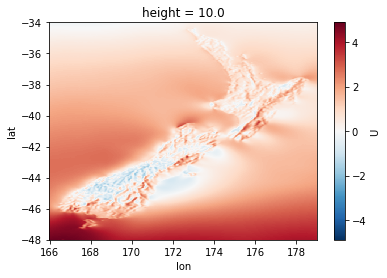

In [12]:
# This is computing the average across time and plotting.
# The progress bar will help you make a decision on whether to go have coffee or not.
# This took me (Marwan) around 7min
with ProgressBar():
    AVG=U_hgt.mean('time').plot()  # computing the average across time and plotting

#### Example 2

[########################################] | 100% Completed |  1min 42.9s


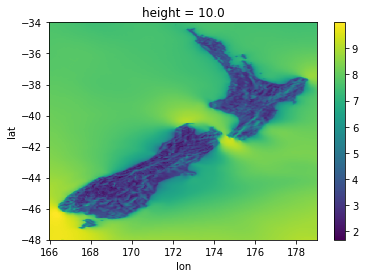

In [13]:
# caluating and plotting wind speed average across the three years but presevring the spaital coordinates
with ProgressBar():
    WS=np.sqrt(U_hgt**2+V_hgt**2)
    WS.mean('time').plot()